# Complete Execution Tree Expansion

## Overview

This notebook implements a **complete execution tree expansion algorithm** that explores all possible execution paths in a BPMN process by enumerating all combinations of simultaneous Choice and Nature nodes.

## Problem Statement

When a BPMN process contains parallel execution branches with multiple decision points (Choice nodes) or probabilistic branches (Nature nodes), the execution tree must capture **all possible combinations** of choices across these simultaneous decision points.

### Key Challenges:

1. **Simultaneous Decisions**: Multiple Choice/Nature nodes can be enabled at the same time (parallel execution)
2. **Combinatorial Explosion**: With N decision points having M alternatives each, we need to explore M^N combinations
3. **Node Identification**: The simulator may assign the same ID to different execution paths, requiring differentiation by impacts and probability
4. **Server Interface**: The server uses transitions with `stop=True` to represent decision points and expects a list of transition IDs as choices

## Algorithm Design

### Core Strategy:

```
For each node to expand:
  1. Identify all enabled stop transitions (decision points)
  2. Group transitions by label (representing Choice/Nature nodes)
  3. Generate cartesian product of all alternatives
  4. For each combination:
     - Call simulator with specific choices
     - Collect resulting child nodes
  5. Deduplicate children by (impacts, probability) signature
  6. Update tree with all unique children
  7. Continue BFS traversal
```

### Example:

If we have:
- **C1** (Choice): 2 alternatives [FD, RD]
- **N1** (Nature): 2 alternatives [HP, LP] with probabilities [0.2, 0.8]

Both enabled simultaneously → **4 combinations** to explore:
1. (FD, HP) → impacts=[X1, Y1], prob=0.2
2. (FD, LP) → impacts=[X2, Y2], prob=0.8
3. (RD, HP) → impacts=[X3, Y3], prob=0.2
4. (RD, LP) → impacts=[X4, Y4], prob=0.8

Each combination produces a unique child node in the execution tree.

## Setup and Imports

In [1]:
import json
import sys
sys.path.append('simulator/src')
sys.path.append('src')
import copy
from itertools import product
from collections import deque
from typing import Any, Dict, List, Optional
import requests
import graphviz
from IPython.display import display
from IPython.core.display import SVG
from src.utils.env import IMPACTS_NAMES

# Configuration
URL = "127.0.0.1"
SIMULATOR_PORT = 8001
SOLVER_PORT = 8000
HEADERS = {"Content-Type": "application/json"}

## Load BPMN Definition

Load the BPMN process definition from JSON file. This contains:
- Process structure (activities, gateways, flows)
- Impact definitions (resources consumed)
- Duration and cost information

In [2]:
with open("bpmn_fig8_bound_135_15.json", "r") as f:
    bpmn_file = f.read()

bpmn_definition = json.loads(bpmn_file)
impacts_names = bpmn_definition.get(IMPACTS_NAMES, [])
print(f"Loaded BPMN: {bpmn_definition.get('expression', '')}")
print(f"Impact dimensions: {impacts_names}")

Loaded BPMN: (Cutting, ((Bending, (HP^[N1]LP)) || (Milling, (FD/[C1]RD))), (HPHS/[C2]LPLS))
Impact dimensions: ['electric_energy', 'worker_hours']


## Create Parse Tree and Visualize BPMN

The solver API converts the BPMN definition into:
1. **BPMN visualization** - Graphical representation of the process
2. **Parse tree** - Hierarchical structure for execution

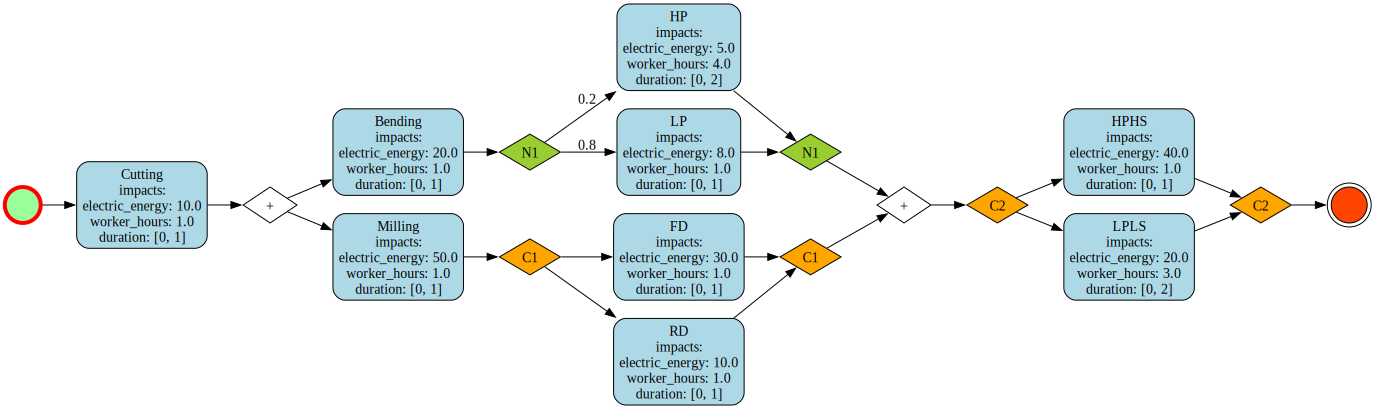

✓ Parse tree created successfully


In [3]:
try:
    # Create BPMN visualization
    resp = requests.get(f"http://{URL}:{SOLVER_PORT}/create_bpmn", json={'bpmn': bpmn_definition}, headers=HEADERS)
    resp.raise_for_status()
    display(SVG(graphviz.Source(resp.json()['bpmn_dot']).pipe(format="svg")))

    # Create parse tree
    resp = requests.get(f"http://{URL}:{SOLVER_PORT}/create_parse_tree", json={'bpmn': bpmn_definition}, headers=HEADERS)
    resp.raise_for_status()
    parse_tree = resp.json()['parse_tree']
    print("✓ Parse tree created successfully")

except requests.exceptions.HTTPError as e:
    print(f"HTTP Error ({resp.status_code}):", resp.json())

## Utility Functions

### Core Utilities:

- **`get_node_by_id`**: Recursive tree traversal to find a node by ID
- **`is_final_node`**: Check if a node represents the final marking (end state)
- **`count_nodes`**: Count total nodes in the tree (for statistics)
- **`get_stop_transitions`**: Identify enabled decision points from the Petri net
- **`node_signature`**: Create unique fingerprint for nodes based on impacts and probability

In [4]:
def get_node_by_id(root: Dict[str, Any], node_id: str) -> Optional[Dict[str, Any]]:
    """Find a node by its ID in the execution tree.
    
    Args:
        root: Root node of the tree
        node_id: ID of the node to find
        
    Returns:
        Node dictionary if found, None otherwise
    """
    if root.get("id") == node_id:
        return root
    for child in root.get("children", []):
        result = get_node_by_id(child, node_id)
        if result:
            return result
    return None


def is_final_node(node: Dict[str, Any], final_marking: Dict[str, Dict[str, float]]) -> bool:
    """Check if a node represents a final marking (end state).
    
    Args:
        node: Node to check
        final_marking: Expected final marking from Petri net
        
    Returns:
        True if node is in final state
    """
    marking = node.get("snapshot", {}).get("marking", {})
    if not marking or not final_marking:
        return False
    for place_name, place_data in final_marking.items():
        if marking.get(place_name, {}).get("token", 0) != place_data.get("token", 0):
            return False
    return True


def count_nodes(node: Dict[str, Any]) -> int:
    """Recursively count all nodes in the tree.
    
    Args:
        node: Root node
        
    Returns:
        Total number of nodes including subtrees
    """
    total = 1
    for child in node.get("children", []):
        total += count_nodes(child)
    return total


def get_stop_transitions(petri_net: Dict[str, Any], marking: Dict[str, Any]) -> Dict[str, List[str]]:
    """Get all enabled stop transitions, grouped by label.
    
    Stop transitions represent decision points (Choice/Nature nodes) in the process.
    This function:
    1. Filters transitions with stop=True
    2. Checks which are enabled in the current marking
    3. Groups them by label (representing the same decision point)
    
    Args:
        petri_net: Petri net structure
        marking: Current marking (token distribution)
        
    Returns:
        Dictionary mapping label -> [transition_ids]
        Example: {'C1': ['t5', 't6'], 'N1': ['t7', 't8']}
    """
    transitions = petri_net.get("transitions", [])
    enabled_stop = {}
    
    for trans in transitions:
        if not trans.get('stop', False):
            continue
        
        trans_id = trans.get('id')
        trans_label = trans.get('label')
        inputs = trans.get('inputs', [])
        
        # Check if transition is enabled (all input places have tokens)
        enabled = True
        for place_id in inputs:
            if place_id not in marking or marking[place_id].get('token', 0) <= 0:
                enabled = False
                break
        
        if enabled:
            if trans_label not in enabled_stop:
                enabled_stop[trans_label] = []
            enabled_stop[trans_label].append(trans_id)
    
    return enabled_stop


def node_signature(node: Dict[str, Any]) -> tuple:
    """Create a unique signature for a node based on impacts and probability.
    
    Since the server may assign the same ID to different execution paths,
    we need to differentiate nodes by their actual state (impacts) and
    probability (for Nature nodes).
    
    Args:
        node: Node to fingerprint
        
    Returns:
        Tuple (impacts, probability) for use as dictionary key
    """
    impacts = tuple(node['snapshot']['impacts'])
    prob = node['snapshot']['probability']
    return (impacts, prob)

print("✓ Utility functions loaded")

✓ Utility functions loaded


## SimulatorClient Class

Client wrapper for the simulator API.

### Key Methods:

- **`bootstrap`**: Initialize simulation with parse tree
- **`expand_node`**: Expand a specific node with given choices

### Important Notes:

- The server operates on `execution_tree.current_node`
- Choices are passed as a list of transition IDs
- Each call returns updated state (petri_net, execution_tree, etc.)

In [5]:
class SimulatorClient:
    """Client for interacting with the simulator API."""
    
    def __init__(self, base_url: str = f"http://{URL}:{SIMULATOR_PORT}/") -> None:
        self.base_url = base_url.rstrip("/") + "/"
        self.session = requests.Session()

    def execute(self, payload: Dict[str, Any]) -> Dict[str, Any]:
        """Execute a request to the simulator.
        
        Args:
            payload: Request payload (bpmn, petri_net, execution_tree, choices)
            
        Returns:
            Response dictionary with updated state
            
        Raises:
            RuntimeError: If server returns an error
        """
        response = self.session.post(self.base_url + "execute", headers=HEADERS, json=payload, timeout=60)
        response.raise_for_status()
        data = response.json()
        if "error" in data:
            raise RuntimeError(f"Simulator error: {data['error']}")
        return data

    def bootstrap(self, parse_tree_payload: Dict[str, Any]) -> Dict[str, Any]:
        """Initialize the simulator with a parse tree.
        
        Args:
            parse_tree_payload: Parse tree from solver
            
        Returns:
            Initial state (bpmn, petri_net, execution_tree)
        """
        payload = {"bpmn": parse_tree_payload}
        return self.execute(payload)

    def expand_node(
        self,
        shared_state: Dict[str, Any],
        node_id: str,
        *,
        choices: Optional[List[str]] = None,
    ) -> Dict[str, Any]:
        """Expand a specific node with given choices.
        
        The server operates on execution_tree.current_node, so we:
        1. Copy the shared state
        2. Set current_node to the node we want to expand
        3. Send the request with optional choices
        
        Args:
            shared_state: Current simulation state
            node_id: ID of node to expand
            choices: Optional list of transition IDs representing choices
            
        Returns:
            Updated state with expanded tree
        """
        exec_tree = copy.deepcopy(shared_state["execution_tree"])
        exec_tree["current_node"] = node_id
        
        request_payload = {
            "bpmn": shared_state["bpmn"],
            "petri_net": shared_state["petri_net"],
            "execution_tree": exec_tree,
        }
        if choices is not None:
            request_payload["choices"] = list(choices)
        
        response = self.execute(request_payload)
        return response

print("✓ SimulatorClient class loaded")

✓ SimulatorClient class loaded


## Complete Tree Expansion Algorithm

### Algorithm Overview:

This is the **core algorithm** that builds the complete execution tree by exploring all combinations of simultaneous Choice/Nature decisions.

### Key Steps:

1. **Initialize**: Bootstrap simulator and setup BFS frontier
2. **For each node in frontier**:
   - Skip if already expanded
   - Check if final state → mark done
   - Get enabled stop transitions (decision points)
   - **Generate all combinations** using cartesian product
   - For each combination:
     - Expand with specific choices
     - Collect child nodes
   - **Deduplicate** children by signature
   - Update tree with unique children
   - Add children to frontier
3. **Continue** until frontier is empty

### Complexity:

- Time: O(N × M^D) where:
  - N = number of nodes in tree
  - M = average alternatives per decision point
  - D = average simultaneous decision points
- Space: O(N) for tree storage

### Debug Output:

The algorithm prints detailed progress:
- Decision points found per node
- Number of combinations to explore
- Each combination and its result
- Unique vs duplicate children
- Final statistics

In [6]:
def build_complete_execution_tree(client: SimulatorClient, parse_tree_payload: Dict[str, Any]) -> Dict[str, Any]:
    """Build the complete execution tree by exploring ALL combinations.

    This algorithm ensures that every possible execution path is explored by:
    1. Identifying simultaneous decision points (enabled stop transitions)
    2. Generating cartesian product of all alternatives
    3. Exploring each combination and collecting unique children
    4. Continuing BFS traversal until all nodes are expanded

    Args:
        client: SimulatorClient instance
        parse_tree_payload: Parse tree from solver

    Returns:
        Complete shared state with fully expanded execution tree
    """
    # Initialize simulator
    shared_state = client.bootstrap(parse_tree_payload)
    final_marking = shared_state["petri_net"]["final_marking"]

    # BFS state
    expanded_nodes = set()
    frontier: deque[str] = deque([shared_state["execution_tree"]["root"]["id"]])
    iteration = 0

    # Main BFS loop
    while frontier:
        iteration += 1
        node_id = frontier.popleft()

        # Skip already expanded nodes
        if node_id in expanded_nodes:
            continue

        print(f"\n[{iteration}] Expanding node: {node_id}")

        # Get node from tree
        node = get_node_by_id(shared_state["execution_tree"]["root"], node_id)
        if not node:
            print(f"  ✗ Node not found")
            continue

        # Check if final state
        if is_final_node(node, final_marking):
            print(f"  ✓ Final marking reached")
            expanded_nodes.add(node_id)
            continue

        # Check if already has children (from previous expansion)
        if node.get("children"):
            children = node["children"]
            print(f"  ℹ Already has {len(children)} children - scheduling them")
            for child in children:
                if child.get("id") not in expanded_nodes:
                    frontier.append(child["id"])
            expanded_nodes.add(node_id)
            continue

        # Get enabled stop transitions (decision points)
        snapshot = node.get("snapshot", {})
        status = snapshot.get("status", {})
        decisions = snapshot.get("decisions", [])
        choices = snapshot.get("choices", [])

        print(f"  • Status: {status}")
        print(f"  • Decisions made: {decisions}")
        print(f"  • Choices made: {choices}")

        marking = snapshot.get("marking", {})
        stop_groups = get_stop_transitions(shared_state["petri_net"], marking)

        if not stop_groups:
            print(f"  ✗ No stop transitions (deadlock or final)")
            expanded_nodes.add(node_id)
            continue

        # Display decision points found
        print(f"  → Found {len(stop_groups)} decision points: {list(stop_groups.keys())}")
        for label, trans_ids in stop_groups.items():
            print(f"     {label}: {len(trans_ids)} alternatives (IDs: {trans_ids})")

        # Generate ALL combinations using cartesian product
        # Example: {C1: [t1, t2], N1: [t3, t4]} → [(t1,t3), (t1,t4), (t2,t3), (t2,t4)]
        choice_lists = [trans_ids for trans_ids in stop_groups.values()]
        all_combinations = list(product(*choice_lists))

        print(f"  → Total combinations to explore: {len(all_combinations)}")

        # Collect all unique children from all combinations
        all_children = {}  # signature -> child_node

        for combo_idx, combination in enumerate(all_combinations):
            choices = list(combination)
            print(f"    • Combination {combo_idx + 1}: {choices}")

            try:
                # Expand with this combination
                temp_state = copy.deepcopy(shared_state)
                response = client.expand_node(temp_state, node_id, choices=choices)

                # Get expanded node from response
                temp_tree = response.get("execution_tree", {})
                expanded_node = get_node_by_id(temp_tree.get("root", {}), node_id)

                if expanded_node and expanded_node.get("children"):
                    for child in expanded_node["children"]:
                        # Use signature (impacts + probability) as unique key
                        sig = node_signature(child)
                        if sig not in all_children:
                            all_children[sig] = copy.deepcopy(child)
                            print(f"      ✓ New branch: impacts={child['snapshot']['impacts']}, prob={child['snapshot']['probability']}")
                        else:
                            print(f"      = Duplicate (already seen)")
                else:
                    print(f"      ⚠ No children created")

            except Exception as e:
                print(f"      ✗ Error: {e}")

        # Update node with ALL unique children
        if all_children:
            print(f"  ✓ Total unique children: {len(all_children)}")
            node_to_update = get_node_by_id(shared_state["execution_tree"]["root"], node_id)
            if node_to_update:
                # Reassign IDs to children to ensure uniqueness
                children_list = []
                for idx, child in enumerate(all_children.values()):
                    child_copy = copy.deepcopy(child)
                    # Create unique ID: parent_id + index
                    child_copy['id'] = f"{node_id}_{idx}"
                    children_list.append(child_copy)
                    # Add to frontier for further expansion
                    frontier.append(child_copy['id'])

                # Update tree
                node_to_update["children"] = children_list

        expanded_nodes.add(node_id)

    # Print final statistics
    total_nodes = count_nodes(shared_state['execution_tree']['root'])
    print(f"\n" + "=" * 60)
    print(f"✓ EXPANSION COMPLETE")
    print(f"  Iterations: {iteration}")
    print(f"  Expanded nodes: {len(expanded_nodes)}")
    print(f"  Total tree nodes: {total_nodes}")
    print("=" * 60)

    return shared_state

print("✓ Expansion algorithm loaded")

✓ Expansion algorithm loaded


## Execute Complete Expansion

Run the complete expansion algorithm.

### Expected Output:

You will see detailed progress for each node:
- Decision points identified
- Combinations being explored
- Children created (unique vs duplicates)
- Final tree statistics

### Performance Notes:

- Execution time depends on:
  - Number of nodes in the process
  - Number of parallel decision points
  - Alternatives per decision point
- For complex processes, this may take several minutes

In [7]:
client = SimulatorClient()
shared_state_complete = build_complete_execution_tree(client, parse_tree)
complete_root = shared_state_complete["execution_tree"]["root"]
print(f"\n✓ Total nodes in complete tree: {count_nodes(complete_root)}")


[1] Expanding node: 0
  • Status: {'0': 1, '1': 1, '2': 1, '3': 0, '4': 0, '5': 0, '6': 0, '7': 0, '8': 0, '9': 0, '10': 0, '11': 0, '12': 0, '13': 0, '14': 0, '15': 0, '16': 0}
  • Decisions made: []
  • Choices made: []
  → Found 3 decision points: ['C1', 'C2', 'N1']
     C1: 2 alternatives (IDs: ['30', '35'])
     C2: 2 alternatives (IDs: ['47', '42'])
     N1: 2 alternatives (IDs: ['15', '20'])
  → Total combinations to explore: 8
    • Combination 1: ['30', '47', '15']
      ✓ New branch: impacts=[80.0, 3.0], prob=1.0
    • Combination 2: ['30', '47', '20']
      = Duplicate (already seen)
    • Combination 3: ['30', '42', '15']
      = Duplicate (already seen)
    • Combination 4: ['30', '42', '20']
      = Duplicate (already seen)
    • Combination 5: ['35', '47', '15']
      = Duplicate (already seen)
    • Combination 6: ['35', '47', '20']
      = Duplicate (already seen)
    • Combination 7: ['35', '42', '15']
      = Duplicate (already seen)
    • Combination 8: ['35', '42'

KeyboardInterrupt: 

## Visualize Execution Tree

Generate a graphical representation of the complete execution tree.

### Visualization Features:

- Nodes show: impacts, probability, execution time
- Edges represent execution transitions
- Current node is highlighted
- Final nodes are marked differently

**Note**: For large trees, the visualization may be very large.

In [ ]:
from paco.parser.dot.execution_tree import get_path_to_current_node, wrapper_execution_tree_to_dot

execution_tree = shared_state_complete["execution_tree"]
current_node_id = execution_tree.get("current_node")
highlight_path = get_path_to_current_node(execution_tree.get("root", {}), current_node_id) or []
dot_source = wrapper_execution_tree_to_dot(execution_tree.get("root", {}), impacts_names, highlight_path)
graph = graphviz.Source(dot_source, format="svg")
display(graph)

## Export Results

Save the complete execution tree to a JSON file for:
- Further analysis
- Pareto frontier computation
- Performance evaluation
- Documentation

In [ ]:
output_file = "complete_execution_tree.json"
with open(output_file, "w") as f:
    json.dump(shared_state_complete["execution_tree"], f, indent=2)
print(f"✓ Execution tree exported to {output_file}")

## Summary

This notebook implements a complete execution tree expansion algorithm that:

### ✅ Features:
- **Complete Exploration**: All combinations of simultaneous decisions
- **Correct Identification**: Uses Petri net stop transitions to find decision points
- **Deduplication**: Differentiates nodes by impacts and probability
- **BFS Traversal**: Systematic exploration of the entire tree
- **Detailed Logging**: Progress tracking and statistics

### 📊 Use Cases:
- Generate complete execution trees for BPMN processes
- Compute Pareto frontiers of non-dominated solutions
- Analyze process complexity and decision impact
- Validate process correctness and completeness

### 🔧 Configuration:
- Adjust `URL`, `SIMULATOR_PORT`, `SOLVER_PORT` for your environment
- Modify BPMN file path as needed
- Customize output file name

### 📝 References:
- BPMN 2.0 Specification
- Petri Net theory for process modeling
- Multi-objective optimization literature